# What are we trying to solve?


The problem that our group chose was trying to determine what kind of blood cell type is depicted within an augmented image of the blood cell. We are trying to differentiate between four different types, which are Eosinophil, Lymphocyte, Monocyte, and Neutrophil. Each class has roughly 3000 augmented images associated with them, which were augmented using the original 410 images in the dataset.

We think this problem is worthwhile because it will allow for extremely quick classification of white blood cells, and eliminate the tedious process of having to manuall differentiate between them.

# Collect Data

We found this dataset on kaggle, but it doesn't say where it was collected. https://www.kaggle.com/paultimothymooney/blood-cells

# Explore Data

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
#Method for getting data from folders

from tqdm import tqdm

def getData(path):
    X = []
    y = []
    z = []
    
    # label 1 is for the type of bloodcell, label 2 is if the cell is mononuclear or polynuclear
    for cell_type in os.listdir(path):
        if not cell_type.startswith('.'):
            if cell_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif cell_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif cell_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif cell_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for fn in tqdm(os.listdir(path + cell_type)):
                img_file = cv2.imread(path + cell_type + '/' + fn)
                if img_file is not None:
                    img_file = cv2.resize(img_file, (80, 60))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z                    

In [3]:
# get the training and test data from our folders
x_train, y_train, z_train = getData('C:/Users/User/Jupyter/bloodpics/dataset2-master/images/TRAIN/')
x_test, y_test, z_test = getData('C:/Users/User/Jupyter/bloodpics/dataset2-master/images/TEST/')

100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:05<00:00, 118.93it/s]


In [4]:
#Shuffles the data so the classes are not grouped sequentially
import random

shuffled = list(zip(x_train, y_train, z_train))

random.shuffle(shuffled)

x_train, y_train, z_train = zip(*shuffled)

In [5]:
shuffledtest = list(zip(x_test, y_test, z_test))

random.shuffle(shuffledtest)

x_test, y_test, z_test = zip(*shuffledtest)

In [6]:
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
z_test = np.asarray(z_test)

In [7]:
#Turns shuffled tuples back into numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
z_train = np.asarray(z_train)

In [8]:
print(x_train.shape)
print(y_train.shape)

(9957, 60, 80, 3)
(9957,)


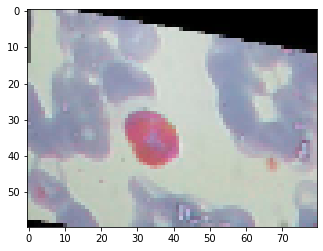

2 EOSINOPHIL
1 POLYNUCLEAR


In [20]:
plt.imshow(x_train[0])
plt.show()
print(f'{y_train[0]} EOSINOPHIL')
print(f'{z_train[0]} POLYNUCLEAR')

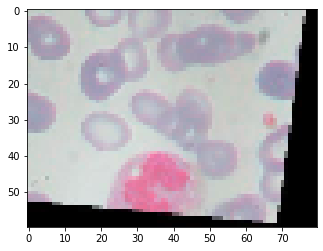

1 NEUTROPHIL
1 POLYNUCLEAR


In [21]:
plt.imshow(x_train[35])
plt.show()
print(f'{y_train[35]} NEUTROPHIL')
print(f'{z_train[35]} POLYNUCLEAR')

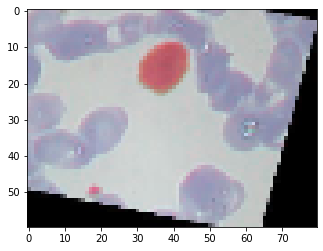

4 LYMPHOCYTE
0 MONONUCLEAR


In [22]:
plt.imshow(x_train[14])
plt.show()
print(f'{y_train[14]} LYMPHOCYTE')
print(f'{z_train[14]} MONONUCLEAR')

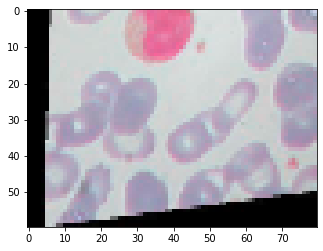

3 MONOCYTE
0 MONONUCLEAR


In [23]:
plt.imshow(x_train[2])
plt.show()
print(f'{y_train[2]} MONOCYTE')
print(f'{z_train[2]} MONONUCLEAR')

# Data Preprocessing

In [10]:
#One hot encode labels so they are all treated equally
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
print(dict_characters)
print(dict_characters2)

{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


# Establish Baseline

The baseline we are using for our model is guessing based on knowing if the nucleus is mononulcear or polynuclear. This would yield a 50% accuracy over time.

# Train and Select Model

In [11]:
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import concatenate, AveragePooling2D, Softmax
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

In [126]:
def make_model():
    inp = Input(shape=(60,80,3))
    k = BatchNormalization()(inp)
    k = Conv2D(32, (7,7), padding="same",activation="relu",strides=(1,1))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(1,1))(k) 
    k = Conv2D(32, (3,3), padding="same",activation="relu",strides=(1,1))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(1,1))(k)
    p = k
    out_conv = []
    
    p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
    p = Dropout(0.1)(p)
    out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
    
    p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
    p = Conv2D(32, (3,3), padding="same",activation="relu")(p)
    p = Dropout(0.1)(p)
    out_conv.append(Conv2D(32, (3,3), padding="same",activation="relu")(p))
    
    p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
    p = Conv2D(32, (5,5), padding="same",activation="relu")(p)
    p = Dropout(0.1)(p)
    out_conv.append(Conv2D(32, (5,5), padding="same",activation="relu")(p))
    
    p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
    p = Conv2D(32, (7,7), padding="same",activation="relu")(p)
    p = Dropout(0.1)(p)
    
    
    out_conv.append(Conv2D(32, (7,7), padding="same",activation="relu")(p))
    
    p = MaxPool2D(pool_size=(2, 2), padding="same",strides=(1,1))(p)
    out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
    
    x = concatenate(out_conv, axis = -1)
    
    k = x
    x = Dropout(0.35)(k)
    x = MaxPool2D(pool_size=(5, 5), padding="same",strides=(1,1))(x)
    x = Flatten()(x)
    #x = Dense(1024,activation="relu")(x)
    #x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    y = Dense(5,activation="softmax")(x)
#    z = Dense(2,activation="softmax")(x)
    model = Model(inp, y)
    opt = optimizers.Adam(lr=0.01,decay=0.0001)
    model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    return model

In [20]:
def make_model3(num_blocks=2):
    inp = Input(shape=(60,80,3))
    k = BatchNormalization()(inp)
    k = Conv2D(32, (7,7), padding="same",activation="relu",strides=(1,1))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(1,1))(k) 
    k = Conv2D(32, (3,3), padding="same",activation="relu",strides=(1,1))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(1,1))(k)
    
    for j in range(num_blocks):
        out_conv = []
        for i in [(1,1),(3,3),(5,5),(0,0)]:
            p = k
            if i == (1,1):
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            elif i == (0,0):
                p = MaxPool2D(pool_size=(2, 2), padding="same",strides=(1,1))(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            else:
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                p = Conv2D(32, i, padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, i, padding="same",activation="relu")(p))
        x = concatenate(out_conv, axis = -1)
        k = x
    x = Dropout(0.5)(k)
    x = MaxPool2D(pool_size=(5, 5), padding="same",strides=(1,1))(x)
    x = Flatten()(x)
    y = Dense(5,activation="softmax")(x)
    model = Model(inp, y)
    opt = optimizers.Adam(lr=0.01,decay=0.0001)
    model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    return model

In [27]:
def make_model2():
    inp = Input(shape=(60,80,3))
    k = BatchNormalization()(inp)
    k = Conv2D(32, (7,7), padding="same",activation="relu",strides=(1,1))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(1,1))(k) 
    k = Conv2D(32, (3,3), padding="same",activation="relu",strides=(1,1))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(1,1))(k)
    p = k
    out_conv = []
    
    p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
    p = Dropout(0.1)(p)
    out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
    
    p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
    p = Conv2D(32, (3,3), padding="same",activation="relu")(p)
    p = Dropout(0.1)(p)
    out_conv.append(Conv2D(32, (3,3), padding="same",activation="relu")(p))
    
    out_conv.append(Conv2D(32, (5,5), padding="same",activation="relu")(p))
    
    p = MaxPool2D(pool_size=(2, 2), padding="same",strides=(1,1))(p)
    out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
    
    x = concatenate(out_conv, axis = -1)
    
    k = x
    x = Dropout(0.2)(k)
    x = MaxPool2D(pool_size=(5, 5), padding="same",strides=(1,1))(x)
    x = Flatten()(x)
    #x = Dense(1024,activation="relu")(x)
    #x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    y = Dense(5,activation="softmax")(x)
#    z = Dense(2,activation="softmax")(x)
    model = Model(inp, y)
    opt = optimizers.Adam(lr=0.01,decay=0.0001)
    model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    return model

In [29]:
model = make_model3(2)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 60, 80, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 60, 80, 3)    12          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 60, 80, 32)   4736        batch_normalization_3[0][0]      
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 60, 80, 32)   0           conv2d_78[0][0]                  
____________________________________________________________________________________________

In [30]:
filepath = "curr_model_inception.{epoch:02d}-{val_accuracy:.5f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=False, mode = "max")
callbacks_list = [checkpoint]
history = model.fit(x_train,
        y_trainHot,
        epochs = 8,
        batch_size = 8,
        validation_data = (x_test,y_testHot),
        callbacks = callbacks_list,
        verbose = 1)

Train on 9957 samples, validate on 2487 samples
Epoch 1/8
1464/9957 [===>..........................] - ETA: 20:30 - loss: 1.9432 - accuracy: 0.0000e+0 - ETA: 10:53 - loss: 21.9301 - accuracy: 0.0000e+ - ETA: 7:41 - loss: 20.0552 - accuracy: 0.0000e+00 - ETA: 6:05 - loss: 21.1033 - accuracy: 0.0312    - ETA: 5:07 - loss: 18.6906 - accuracy: 0.100 - ETA: 4:29 - loss: 16.5803 - accuracy: 0.125 - ETA: 4:02 - loss: 14.4214 - accuracy: 0.142 - ETA: 3:41 - loss: 12.8235 - accuracy: 0.203 - ETA: 3:25 - loss: 11.6314 - accuracy: 0.194 - ETA: 3:12 - loss: 10.6055 - accuracy: 0.212 - ETA: 3:02 - loss: 10.0014 - accuracy: 0.204 - ETA: 2:53 - loss: 9.3151 - accuracy: 0.229 - ETA: 2:45 - loss: 8.7952 - accuracy: 0.21 - ETA: 2:39 - loss: 8.2685 - accuracy: 0.21 - ETA: 2:33 - loss: 7.8005 - accuracy: 0.23 - ETA: 2:28 - loss: 7.4270 - accuracy: 0.24 - ETA: 2:24 - loss: 7.1197 - accuracy: 0.24 - ETA: 2:20 - loss: 6.8272 - accuracy: 0.24 - ETA: 2:17 - loss: 6.5461 - accuracy: 0.24 - ETA: 2:14 - loss: 6.2

In [52]:
model.load_weights("curr_model_inception.03-0.84881.hdf5")

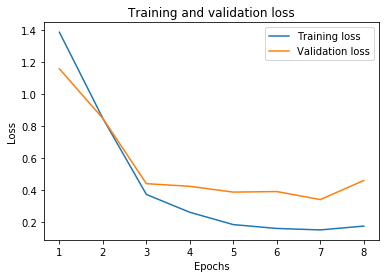

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

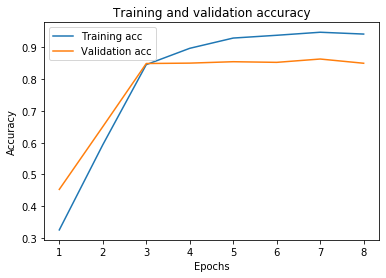

In [32]:
history_dict = history.history
history_dict.keys()
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [53]:
predictions = model.predict(x_test)

In [54]:
predictionsmax = np.argmax(predictions,axis=1)

In [35]:
y_test

array([4, 3, 1, ..., 3, 2, 4])

In [55]:
count = 0
length = len(y_test)
for i in range(length):
    if y_test[i] == predictionsmax[i]:
        count = count + 1

        
print(count / length)

0.8488138319260152


# Maintain, Monitor, and Deploy

To maintain this model, we could continually scrape and collect new data when it is available. We could also host a website that displays the models outputs as input is fed in to see how well it generalizes when it is actually deployed.

# Conclusions

When we first started working with this dataset, our model was not nearly complex enough to distinguish between the images. 
We thought that maybe the images were too closely correlated for a model to make any kind of accurate predictions on. This led us to think that maybe we would have to change pixel intensities on the images to make the important parts stand out more. Before trying that, we made the model a lot more complex, and it turns out that we did not necessarily need to do that at all.

We learned that CNN's are great for this kind of problem, as the same general nucleus appears in different parts of the image, which the CNN can adapt to and recognize. We think if we had more time to feature engineer the data, it would have been possible to achieve better accuracy, but we simply did not have the time do so, but we might revisit that in the future.